# Arima from scratch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
df = pd.read_csv('data.csv',parse_dates=True,index_col='date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['Value']

In [ ]:
df

,Value
date,
1993-01,7.021576e+05
1993-02,2.726925e+06
1993-03,4.730319e+06
1993-04,7.378368e+06
1993-05,1.168075e+07
...,...
1998-08,1.506393e+08
1998-09,1.482977e+08
1998-10,1.518896e+08


Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

In [ ]:
def AR(p,df):
    df_temp = df

  #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_test,theta,intercept,RMSE]

In [ ]:
def MA(q,res):

    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # res_train_2[['Residuals','Predicted_Values']].plot()

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    res_test[['Residuals','Predicted_Values']].plot()

    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta,intercept,RMSE]

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

<h1>
We break down the ARIMA Model into 3 steps:

1. Making the data stationary by differencing. (I)
2. Fitting an AR model. (AR)
3. Fitting an MA model on the residuals. (MA)
4. Getting Back Original data

</h1>

#Step 1 : Making the data stationary

Different techniques can be used to make the data stationary, used log and differencing. The additional diff(12) is remove the seasonality.

In [ ]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.225226609716356
p-value : 7.807176920051248e-06
Number of Lags Used : 3
Number of Observations Used : 55
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='date'>

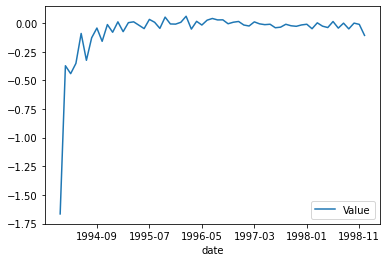

In [ ]:
# print(df_testing.to_string())
df_testing.plot()

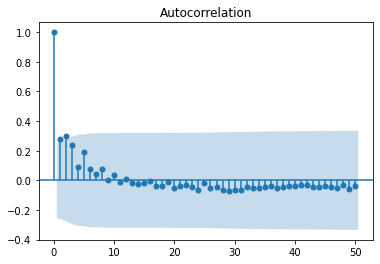

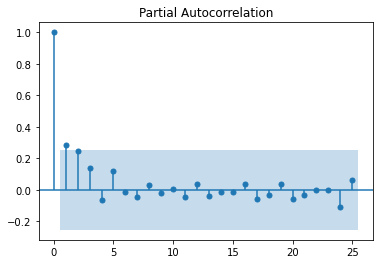

In [ ]:
ACF = plot_acf(df_testing.dropna(),lags=25)
PACF = plot_pacf(df_testing.dropna(),lags=25)

In [ ]:
#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [ ]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
    [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
    if(RMSE<best_RMSE):
        best_RMSE = RMSE
        best_p = i

print(best_p)

The RMSE is : 0.032388648408077265 , Value of p :  1
The RMSE is : 0.03325009798919133 , Value of p :  2
The RMSE is : 0.029558050939839795 , Value of p :  3
The RMSE is : 0.028285801000846898 , Value of p :  4
The RMSE is : 0.03151488059849384 , Value of p :  5
The RMSE is : 0.03225960836393791 , Value of p :  6
The RMSE is : 0.02759031061158076 , Value of p :  7
The RMSE is : 0.03467131518841899 , Value of p :  8
The RMSE is : 0.03074036259116769 , Value of p :  9
The RMSE is : 0.03256948869494694 , Value of p :  10
The RMSE is : 0.031246634780044576 , Value of p :  11
The RMSE is : 0.035679771999742656 , Value of p :  12
The RMSE is : 0.031805101515395943 , Value of p :  13
The RMSE is : 0.03243678373356786 , Value of p :  14
The RMSE is : 0.0480065803083675 , Value of p :  15
The RMSE is : 0.06013809510311503 , Value of p :  16
The RMSE is : 0.05737216043431305 , Value of p :  17
The RMSE is : 0.11567845252209927 , Value of p :  18
The RMSE is : 0.1842163299370902 , Value of p :  1

In [ ]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

The RMSE is : 0.02759031061158076 , Value of p :  7


<AxesSubplot:xlabel='date'>

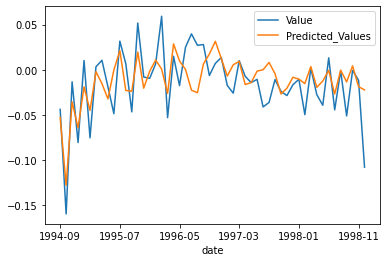

In [ ]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

In [ ]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

<AxesSubplot:ylabel='Density'>

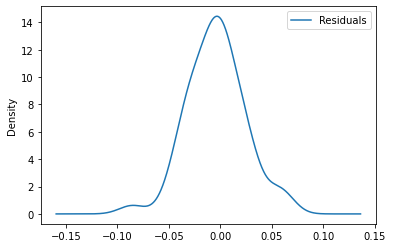

In [ ]:
res.plot(kind='kde')

The RMSE is : 0.03198402156567749 , Value of q :  1
The RMSE is : 0.03298943022776587 , Value of q :  2
The RMSE is : 0.03408338236742454 , Value of q :  3
The RMSE is : 0.03450430781256752 , Value of q :  4
The RMSE is : 0.03535131908637556 , Value of q :  5
The RMSE is : 0.03586708191143001 , Value of q :  6
The RMSE is : 0.03718574869751801 , Value of q :  7
The RMSE is : 0.037286951086643504 , Value of q :  8
The RMSE is : 0.03807875111483282 , Value of q :  9
The RMSE is : 0.03736485660629247 , Value of q :  10
The RMSE is : 0.03790304289242748 , Value of q :  11
The RMSE is : 0.04337445915271736 , Value of q :  12
1


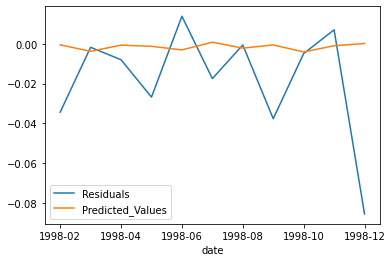

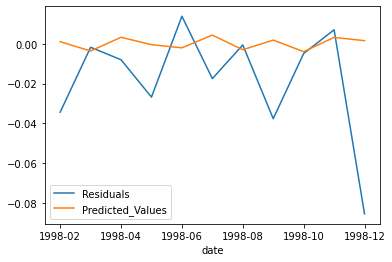

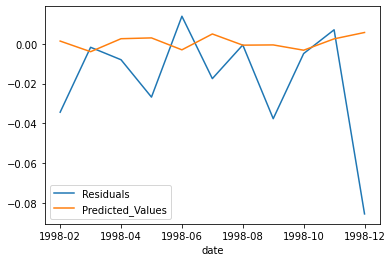

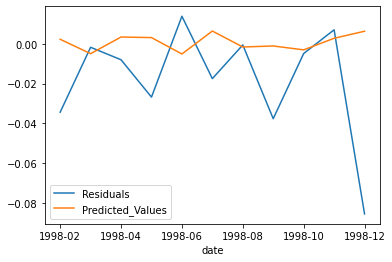

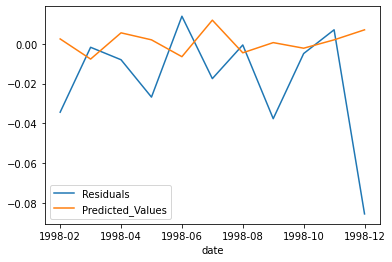

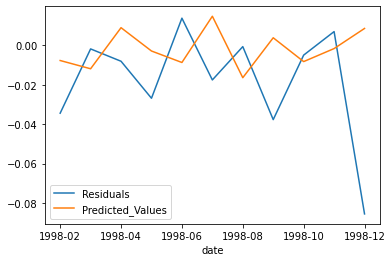

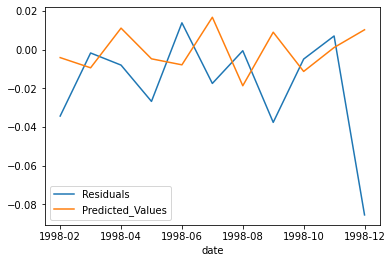

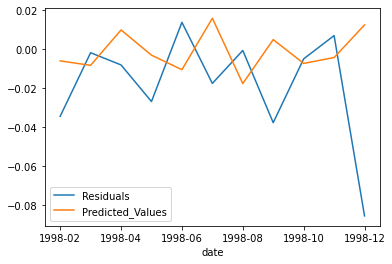

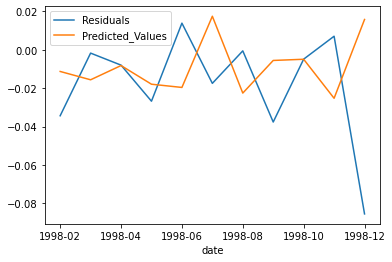

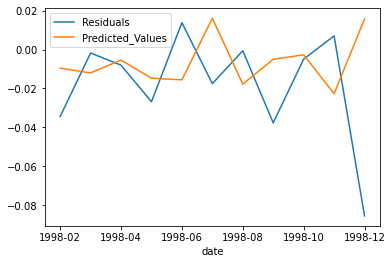

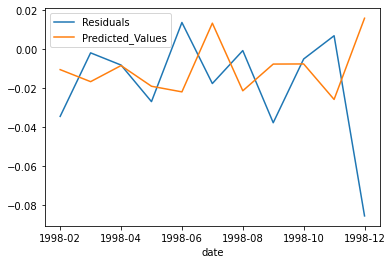

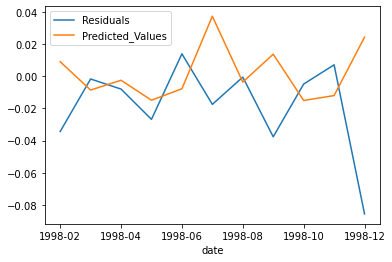

In [ ]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
    [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
    if(RMSE<best_RMSE):
        best_RMSE = RMSE
        best_q = i

print(best_q)

The RMSE is : 0.03198402156567749 , Value of q :  1
[[0.09510917]]
[-0.00053678]


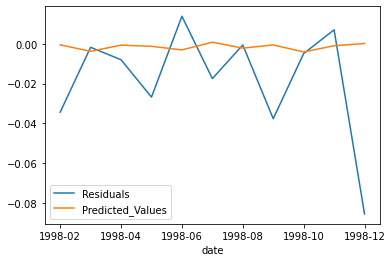

In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [ ]:
res_c = pd.concat([res_train,res_test])

In [ ]:
res_c

,Residuals,Shifted_values_1,Predicted_Values
date,,,
1994-10,-0.031686,0.009048,0.000324
1994-11,0.022175,-0.031686,-0.003550
1994-12,-0.016185,0.022175,0.001572
1995-01,0.029131,-0.016185,-0.002076
1995-02,-0.030341,0.029131,0.002234
1995-03,0.005497,-0.030341,-0.003422
1995-04,0.025826,0.005497,-0.000014
1995-05,0.013401,0.025826,0.001919
1995-06,-0.048368,0.013401,0.000738


In [ ]:
df_c.Predicted_Values += res_c.Predicted_Values

<AxesSubplot:xlabel='date'>

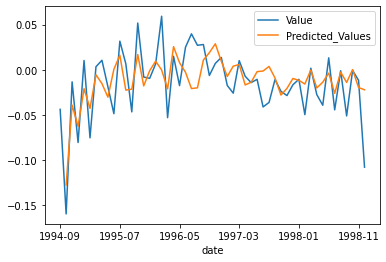

In [ ]:
df_c[['Value','Predicted_Values']].plot()

In [ ]:
# Step 4 : Getting Back Original data

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [ ]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [ ]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Predicted_Values
date,,,,,,,,,
1994-09,4.647984e+07,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,-1.665408,NaN
1994-10,4.661549e+07,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,4.813179e+07
1994-11,4.759123e+07,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,4.638252e+07
1994-12,6.190363e+07,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,6.301268e+07
1995-01,6.624558e+07,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,6.421018e+07
1995-02,4.512608e+07,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,4.662025e+07
1995-03,5.411343e+07,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,5.363294e+07
1995-04,5.484414e+07,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,5.344514e+07
1995-05,5.991497e+07,0.010533,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,5.923097e+07


<AxesSubplot:xlabel='date'>

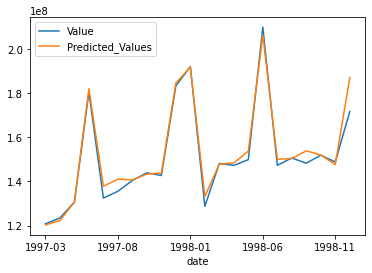

In [ ]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()

# Time Series Modeling with Prophet

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
#reading file
df = pd.read_excel("superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [ ]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [ ]:
#minimum and maximum dates
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [ ]:
#removing columns we don't need and check if there is any missing value
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [ ]:
#furniture#['Order Date'].unique()
#furniture = furniture.groupby(['Order Date']).sum().reset_index()
#furniture

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


In [ ]:
#groupby index date
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
#Indexing with Time Series Data
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [ ]:
#we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.
y = furniture['Sales'].resample('MS').mean()

In [ ]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

In [ ]:
y

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

In [ ]:
furniture['2017':].reset_index().sort_values('Order Date',ascending=True)

,Order Date,Sales
0,2017-01-01,975.4900
1,2017-01-02,913.4300
2,2017-01-08,892.9800
3,2017-01-12,37.6800
4,2017-01-13,212.9400
...,...,...
253,2017-12-24,1393.4940
254,2017-12-25,832.4540
255,2017-12-28,551.2568
256,2017-12-29,2330.7180


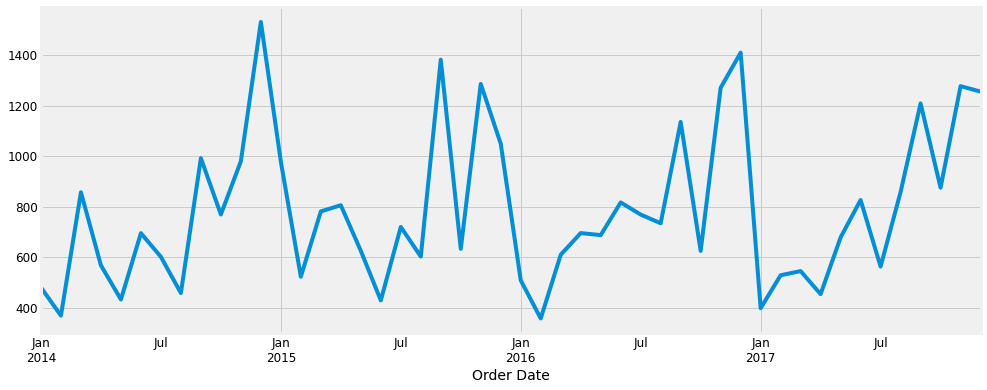

In [ ]:
#visualizing time-series data
y.plot(figsize=(15, 6))
plt.show()

In [ ]:
#selecting furniture and office supplies
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [ ]:
#data preparation
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


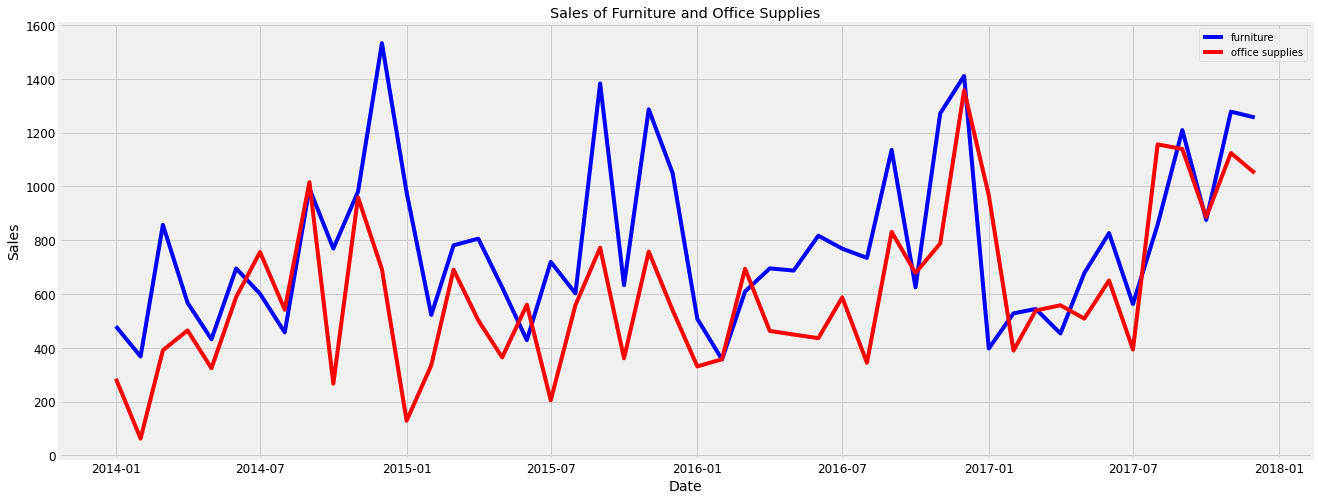

In [ ]:
#plotting time series
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [ ]:
#craeating prophet model
from fbprophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
Prophet?

<Figure size 1296x432 with 0 Axes>

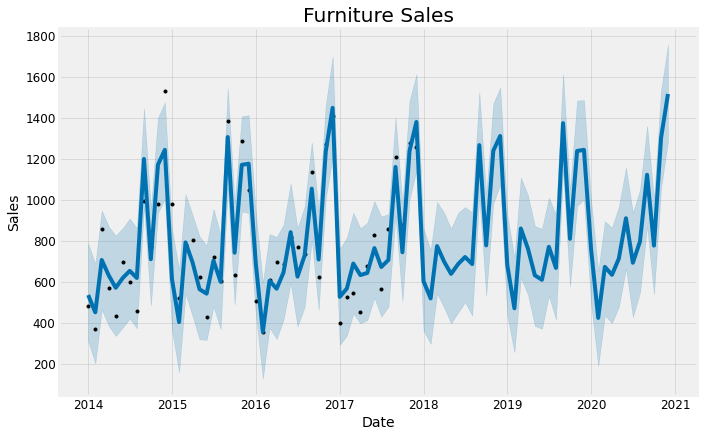

In [ ]:
#plotting furniture forecast
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

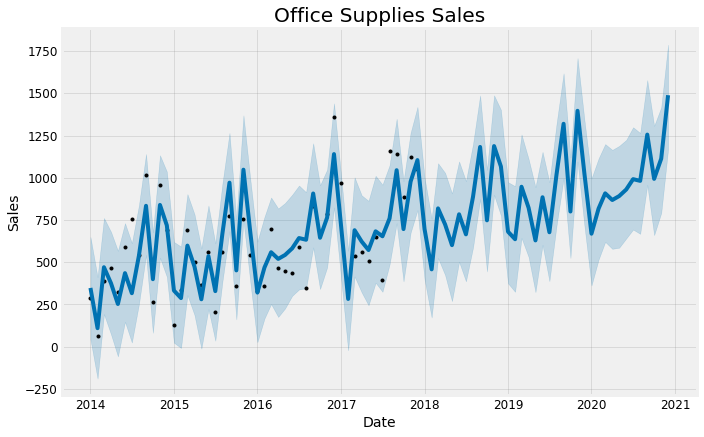

In [ ]:
#plotting office supplies sales forecast
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

In [ ]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,309.922556,786.346471,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,202.111875,687.332209,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,464.887058,946.786754,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,384.326611,868.420907,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,335.894138,825.026923,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


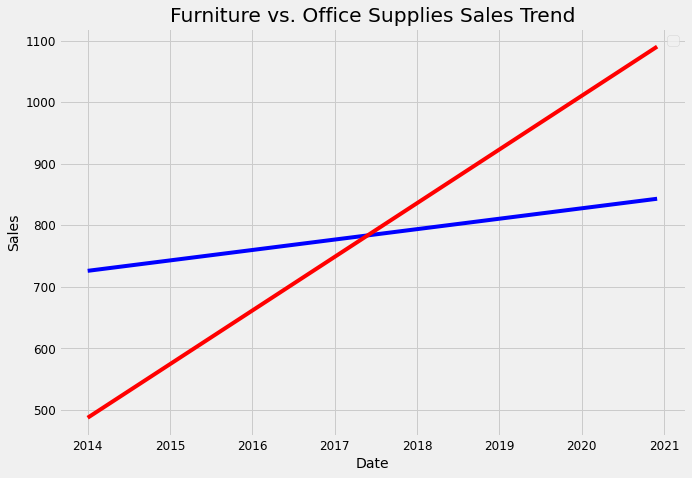

In [ ]:
#trend and forecast visualisation
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

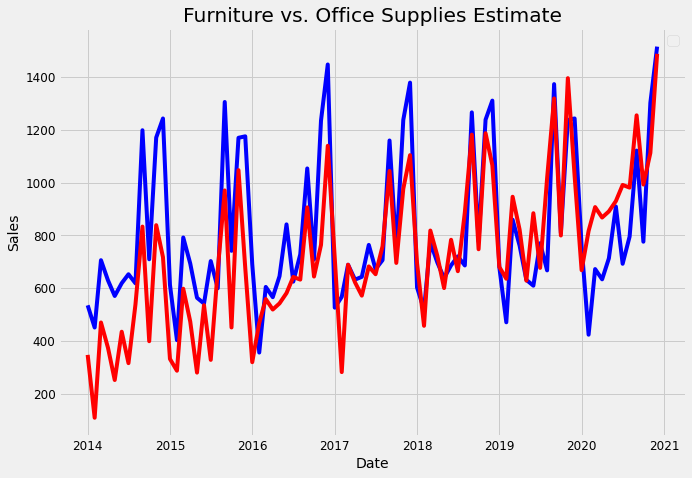

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

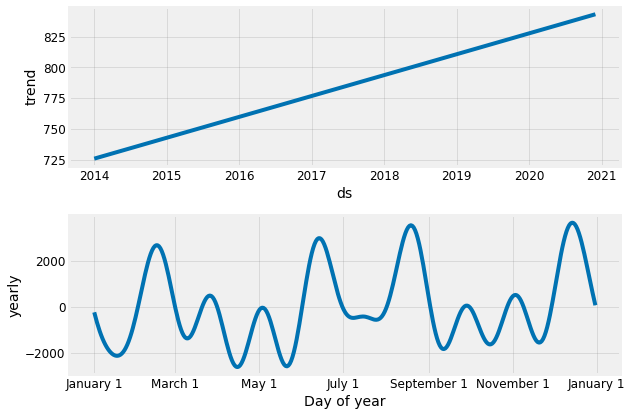

In [ ]:
#plot components of time-series
furniture_model.plot_components(furniture_forecast);

# Time-series modeling with NeuralProphet


In [ ]:
from neuralprophet import NeuralProphet

In [ ]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [ ]:
#removing columns we don't need and check if there is any missing value
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [ ]:
#groupby index date
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
furniture = furniture.set_index('Order Date')

In [ ]:
#we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.
y = furniture['Sales'].resample('MS').mean()

In [ ]:
#rename column names as neural prophet expect time-series as ds and value to predict as y
y= y.reset_index()
y.rename(columns={"Order Date": "ds", "Sales": "y"}, inplace=True)

In [ ]:
y.head()

,ds,y
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188


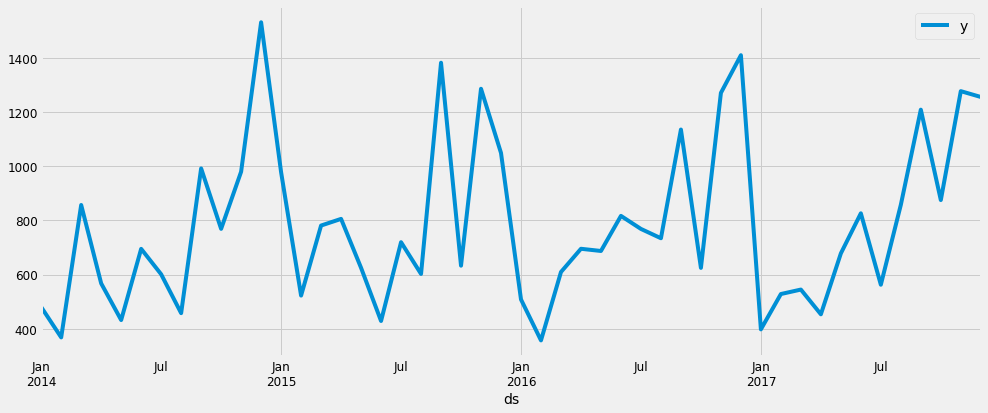

In [ ]:
y.plot(x='ds',y='y',figsize=(15, 6))
plt.show()

In [ ]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=0,
    d_hidden=None,     # Dimension of hidden layers of AR-Net
    ar_sparsity=None,  # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True
)

In [ ]:
metrics = model.fit(y, validate_each_epoch=True, freq="MS")
future = model.make_future_dataframe(y, periods=10, n_historic_predictions=len(y))
forecast = model.predict(future)

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.15E-02, min: 1.78E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.15E-02, min: 1.78E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 8.82E-02
INFO:NP.utils_torch:learning rate range test selected lr: 8.82E-02
Epoch[40/40]: 100%|█| 40/40 [00:00<00:00, 47.25it/s, SmoothL1Loss=0.00837, MAE=110, MSE=1.86e+4, RegLoss=0, MAE_val=148


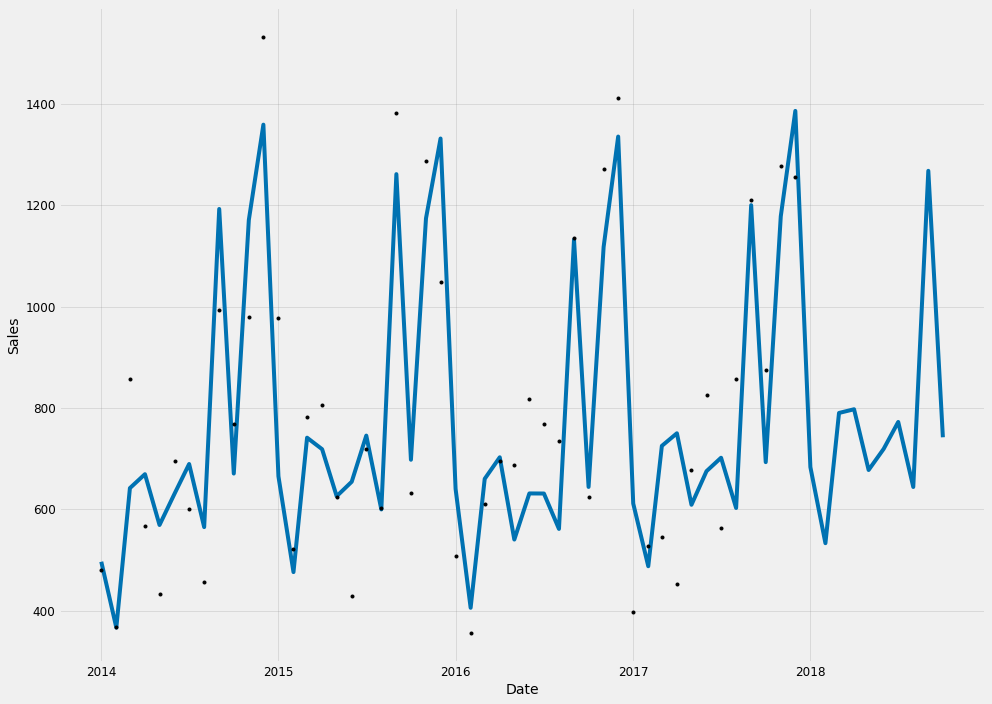

In [ ]:
#plotting predictions
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, xlabel="Date", ylabel="Sales", ax=ax);

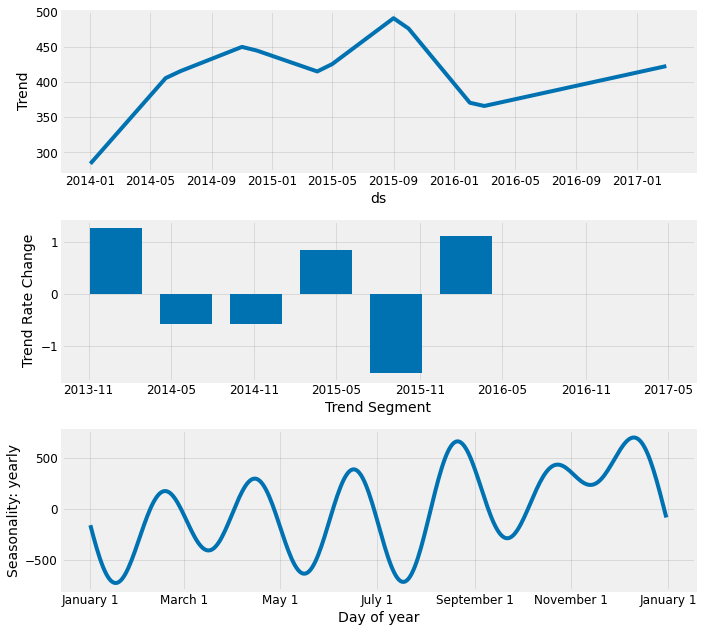

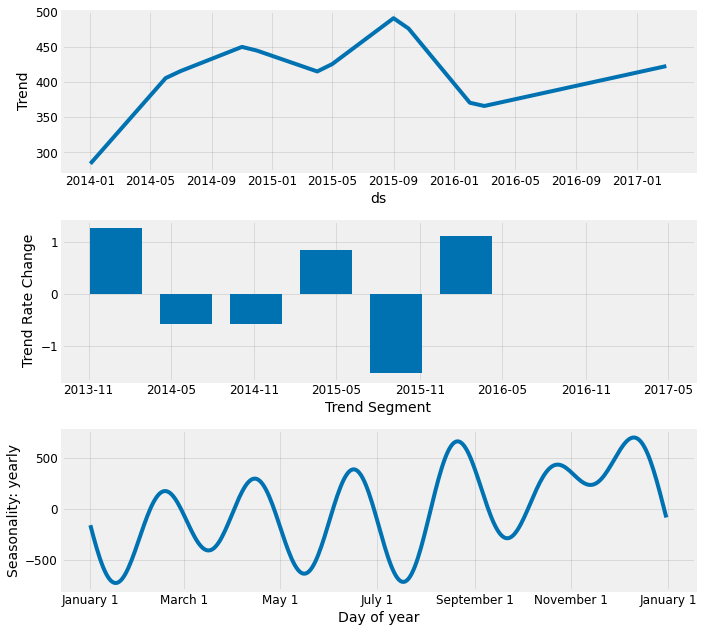

In [ ]:
#plotting components of model
model.plot_parameters()